In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

2023-01-01 18:54:55.763951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading Dataset

In [2]:
#Setting up Directory's

#Train images Directory
train_dir = 'input/diabetic-retinopathy-balanced/train/'
#Test Images Directory
test_dir = 'input/diabetic-retinopathy-balanced/test/'
#Validation Images Directory
val_dir = 'input/diabetic-retinopathy-balanced/val/'

In [3]:
#defining function to load datasets
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train.head()

0 Completed
1 Completed
4 Completed
3 Completed
2 Completed


,image,label
0,input/diabetic-retinopathy-balanced/train/0/22...,0
1,input/diabetic-retinopathy-balanced/train/0/34...,0
2,input/diabetic-retinopathy-balanced/train/0/17...,0
3,input/diabetic-retinopathy-balanced/train/0/14...,0
4,input/diabetic-retinopathy-balanced/train/0/23...,0


In [5]:
os.listdir()

['.DS_Store',
 'input',
 'Diabetic Retinopathy Image Classification.ipynb',
 '.ipynb_checkpoints',
 '.idea']

<AxesSubplot:xlabel='label', ylabel='count'>

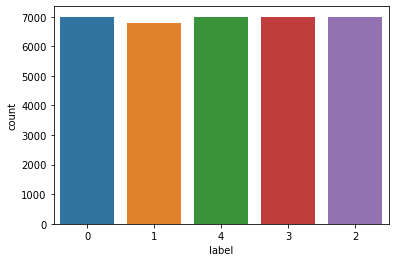

In [6]:
sns.countplot(train['label'])

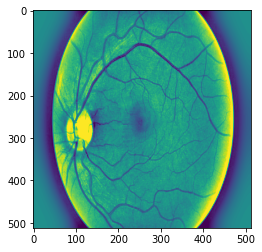

In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img)

### Creating dataset

In [8]:
#setting parameters
batch_size = 32
img_height = 180
img_width = 180

image_size = img_height, img_width

In [9]:
#Images Directory
train_dir = 'input/diabetic-retinopathy-balanced/train/'
test_dir = 'input/diabetic-retinopathy-balanced/test/'
val_dir = 'input/diabetic-retinopathy-balanced/val/'

In [10]:
#Creating Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2,
    subset = "training",
    seed=777,
    image_size = (img_height, img_width),
    batch_size = (batch_size))

Found 34792 files belonging to 5 classes.
Using 27834 files for training.


2023-01-01 18:55:10.355238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
#Creating Validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 777,
    image_size = (img_height, img_width),
    batch_size= (batch_size))

Found 9940 files belonging to 5 classes.
Using 1988 files for validation.


['0', '1', '2', '3', '4']


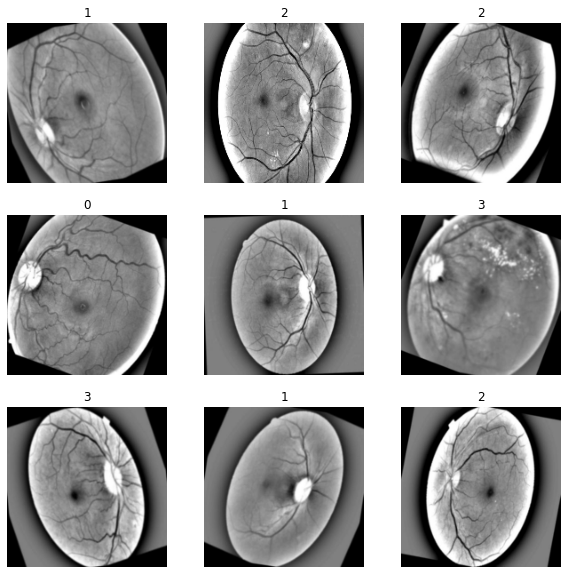

In [12]:
#First 9 images from training set

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### BUILDING THE MODEL #1

In [13]:
#Instantiating our model with rescaling
model = Sequential([layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])

num_classes = len(class_names)

#Adding Layers
model.add(Conv2D(16, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(Dropout(0.7))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.7))
#fully connected layer
model.add(Dense(128, activation='relu'))
#prediction layer
model.add(Dense(num_classes, name = 'preds'))


#### Compiling the model 

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

In [17]:
#Setting parameters for steps per epoch and validation steps
steps_per_epoch = len(train_ds)//batch_size
validation_steps = len(val_ds)//batch_size 

#Fitting the data and running our model
history = model.fit(train_ds, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=val_ds,
                    validation_steps =validation_steps,
                    epochs= 25)

Epoch 1/25
27/27 [==============================] - 12s 425ms/step - loss: 1.3092 - accuracy: 0.4005 - val_loss: 1.3495 - val_accuracy: 0.4375
Epoch 2/25
27/27 [==============================] - 14s 510ms/step - loss: 1.3424 - accuracy: 0.4028 - val_loss: 1.3561 - val_accuracy: 0.4375
Epoch 3/25
27/27 [==============================] - 16s 603ms/step - loss: 1.3263 - accuracy: 0.3970 - val_loss: 1.4061 - val_accuracy: 0.3438
Epoch 4/25
27/27 [==============================] - 18s 650ms/step - loss: 1.3016 - accuracy: 0.4259 - val_loss: 1.2732 - val_accuracy: 0.5000
Epoch 5/25
27/27 [==============================] - 20s 726ms/step - loss: 1.3161 - accuracy: 0.4120 - val_loss: 1.3669 - val_accuracy: 0.3125
Epoch 6/25
27/27 [==============================] - 26s 977ms/step - loss: 1.2896 - accuracy: 0.3877 - val_loss: 1.2566 - val_accuracy: 0.4375
Epoch 7/25
27/27 [==============================] - 22s 801ms/step - loss: 1.2898 - accuracy: 0.4213 - val_loss: 1.3883 - val_accuracy: 0.4375

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

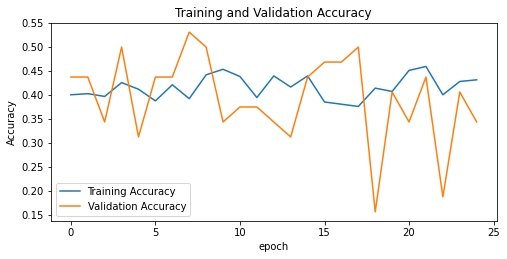

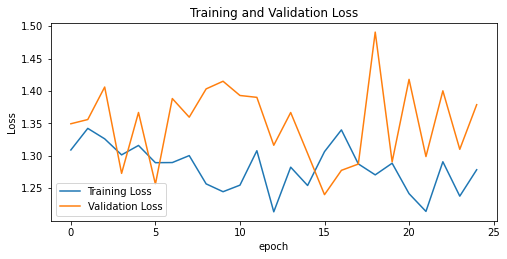

In [61]:
#Visualization for Training and Validation Accuracy
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")

#Data Visualization for Training and Validation Loss
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = "lower left")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")

### Transfer Learning
#### Configuring the dataset for performance

In [36]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)

#### Creating base model from the pre-trained model

In [38]:
#Creating the base model from the pre-trained model VGG19
from keras.applications import VGG19
cnn_base = VGG19(weights = 'imagenet', include_top = False, input_shape =(img_height, img_width, 3))

In [39]:
#Taking a look at the base model architecture
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [40]:
#Generating model layers
from keras import models
from keras import layers
from keras import optimizers

num_classes = len(class_names)

model = models.Sequential([layers.Rescaling(1./255, input_shape=(img_height, img_width, 3))])
model.add(cnn_base)
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(64, activation ='relu'))
model.add(Dense(num_classes, name = 'preds'))

In [41]:
#Checking whether layer is trainable
for layer in model.layers:
    print(layer.name, layer.trainable) 

rescaling_3 True
vgg19 True
max_pooling2d_6 True
flatten_4 True
dense_7 True
dense_8 True
preds True


In [42]:
#freezing cnn_base layer
cnn_base.trainable = False

#Verification cnn_base model is frozen
for layer in model.layers:
    print(layer.name, layer.trainable) 

rescaling_3 True
vgg19 False
max_pooling2d_6 True
flatten_4 True
dense_7 True
dense_8 True
preds True


In [43]:
#model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 128)               262272    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                      

In [44]:
#compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [65]:
history = model.fit(train_ds, 
                    steps_per_epoch=steps_per_epoch, 
                    validation_data=val_ds,
                    validation_steps =validation_steps,
                    epochs = 25)

Epoch 1/25
27/27 [==============================] - 165s 6s/step - loss: 1.1988 - accuracy: 0.4850 - val_loss: 1.1375 - val_accuracy: 0.5938
Epoch 2/25
27/27 [==============================] - 189s 7s/step - loss: 1.1566 - accuracy: 0.4942 - val_loss: 1.0389 - val_accuracy: 0.5000
Epoch 3/25
27/27 [==============================] - 181s 7s/step - loss: 1.1506 - accuracy: 0.5069 - val_loss: 1.2189 - val_accuracy: 0.5312
Epoch 4/25
27/27 [==============================] - 178s 7s/step - loss: 1.1880 - accuracy: 0.4769 - val_loss: 0.9770 - val_accuracy: 0.5625
Epoch 5/25
27/27 [==============================] - 179s 7s/step - loss: 1.2477 - accuracy: 0.4502 - val_loss: 1.2857 - val_accuracy: 0.4375
Epoch 6/25
27/27 [==============================] - 179s 7s/step - loss: 1.1990 - accuracy: 0.4803 - val_loss: 1.1276 - val_accuracy: 0.5000
Epoch 7/25
27/27 [==============================] - 169s 6s/step - loss: 1.1364 - accuracy: 0.4896 - val_loss: 1.0671 - val_accuracy: 0.5000
Epoch 8/25
27

### Visualization of Learning Curves when using VGG19 as a fixed feautre extractor

In [66]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

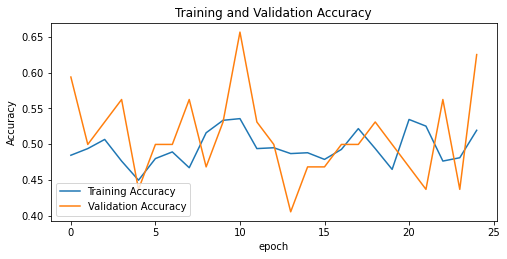

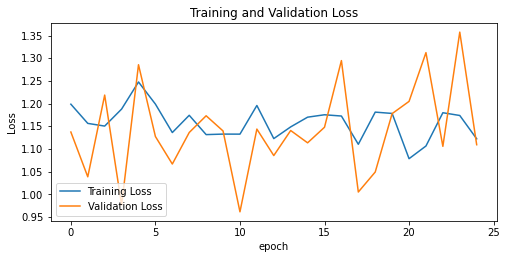

In [67]:
#Visualization for Training and Validation Accuracy after transfer learning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")

#Data Visualization for Training and Validation Loss after Transfer learning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = "lower left")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")

### Fine Tuning
#### Un-freezing the top layers of the model

In [69]:
#Unfreezing the base model
cnn_base.trainable = False

In [72]:
#Counting number of layers are in the base model
print("number of layers in the base model:", len(cnn_base.layers))

#Fine tuning from this layer forwards
fine_tune_at = 22

#Freezing the layers before the 'fine_tune_at' layer
for layer in cnn_base.layers[:fine_tune_at]:
    layer.trainable = False

number of layers in the base model: 22


In [73]:
#Model Summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 5, 5, 512)         20024384  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 2, 2, 512)        0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 128)               262272    
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                      

In [74]:
#compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
#Running The Model
historyfined = model.fit(train_ds,
                        epochs = 50,
                        initial_epoch = history.epoch[-1],
                        steps_per_epoch=steps_per_epoch, 
                        validation_data=val_ds,
                        validation_steps =validation_steps)

Epoch 25/50
27/27 [==============================] - 188s 7s/step - loss: 1.0981 - accuracy: 0.5069 - val_loss: 1.1578 - val_accuracy: 0.5000
Epoch 26/50
27/27 [==============================] - 183s 7s/step - loss: 1.1605 - accuracy: 0.5058 - val_loss: 1.0260 - val_accuracy: 0.6250
Epoch 27/50
27/27 [==============================] - 177s 7s/step - loss: 1.1379 - accuracy: 0.5127 - val_loss: 0.8682 - val_accuracy: 0.7188
Epoch 28/50
27/27 [==============================] - 171s 6s/step - loss: 1.1442 - accuracy: 0.5069 - val_loss: 0.9987 - val_accuracy: 0.5938
Epoch 29/50
27/27 [==============================] - 175s 7s/step - loss: 1.1983 - accuracy: 0.4792 - val_loss: 1.0521 - val_accuracy: 0.6562
Epoch 30/50
27/27 [==============================] - 177s 7s/step - loss: 1.1388 - accuracy: 0.4942 - val_loss: 1.2343 - val_accuracy: 0.4375
Epoch 31/50
27/27 [==============================] - 178s 7s/step - loss: 1.0961 - accuracy: 0.5220 - val_loss: 1.1974 - val_accuracy: 0.4688
Epoch 

In [77]:
acc = historyfined.history['accuracy']
val_acc = historyfined.history['val_accuracy']
loss = historyfined.history['loss']
val_loss = historyfined.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

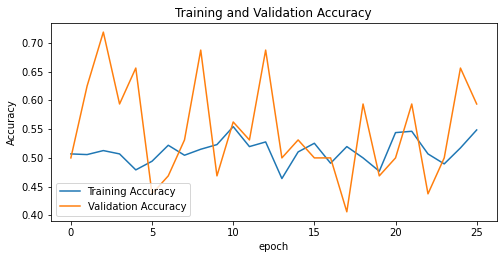

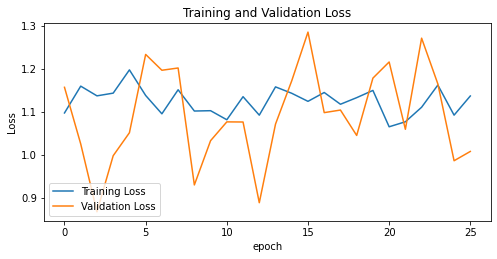

In [78]:
#Visualization for Training and Validation Accuracy after Fine Tuning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")

#Data Visualization for Training and Validation Loss after Fine Tuning
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = "lower left")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")